In [10]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

In [11]:
#Load the data
extension = "nb_ot_nh"
print(f"-------------------------------- Load MH {extension} --------------------------------")
name_experiment = "mh_phi_phi_" + extension
path_start = "./outputs/" + name_experiment + "/"
lst_data = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load MH nb_ot_nh --------------------------------
Loaded: ./outputs/mh_phi_phi_nb_ot_nh/2024-08-31/14-19-54_438/all.json


In [12]:
# Reconstruct all rules MH
all_rules = []
all_likelihoods = []
all_weights = []
all_prev_rules_ind = []
for data in lst_data:
    nb_particles = data["metrics"]["nb_particles"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules = np.concatenate(all_rules, axis=0)
all_likelihoods = np.concatenate(all_likelihoods, axis=0)
all_weights = np.concatenate(all_weights, axis=0)
all_prev_rules_ind = np.concatenate(all_prev_rules_ind, axis=0)

# Print rules

In [13]:
# Compare best rule for MH
# Best rules for each seed
best_taken = 1000
best_rules_ind_seed = np.argsort(-all_likelihoods, axis=1)[:,:best_taken]
best_rules = np.take_along_axis(all_rules, best_rules_ind_seed, axis=1)
best_likelihoods = np.take_along_axis(all_likelihoods, best_rules_ind_seed, axis=1)
best_rules_ind = np.argsort(-best_likelihoods.flatten())
for incr, ind in enumerate(best_rules_ind):
    seed = ind % all_rules.shape[0]
    unravel_ind = np.unravel_index(ind, best_rules.shape)
    print(
        f"-----rule-----:{incr}({seed}): {repr(best_rules[unravel_ind])}, likelihood: {best_likelihoods[unravel_ind]:2f}"
    )

-----rule-----:0(4): 'The rule for opening and closing the door is likely to be based on matching the color, size, and type of the object you are holding with specific conditions that signal the correct action. The puzzle seems to imply that, similar to the earlier rule about the magical relic, the correct action—opening the door—is associated with holding an object that aligns with a \'healthy\' descriptor within the given attributes. The pattern suggests that "healthy" could correlate', likelihood: -43.479782
-----rule-----:1(2): '"To open the door when it is closed, choose a key that matches the color (red, green, blue) of the puzzle piece you are holding. If the puzzle piece is red, use a red key. If it is green, use a green key. If it is blue, use a blue key. The size (small, medium, large) does not affect the rule but may dictate the difficulty of solution."', likelihood: -45.943779
-----rule-----:2(5): "Rule: Hold the object (key, card, or ball) that matches the description prov

# Individual Analysis

## Metropolis Hasting analysis


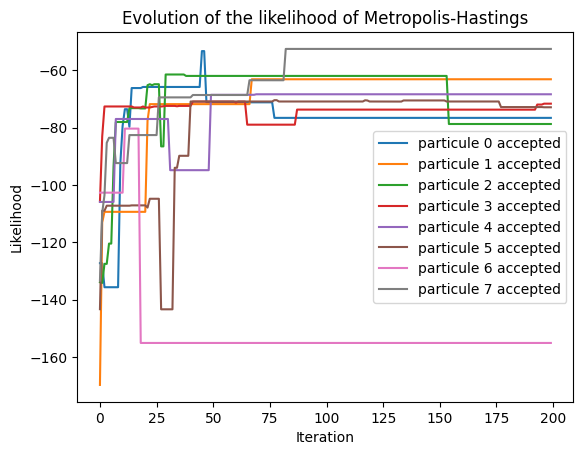

In [14]:
plt.figure()
for seed in range(all_rules.shape[0]):
    plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis-Hastings")
plt.show()


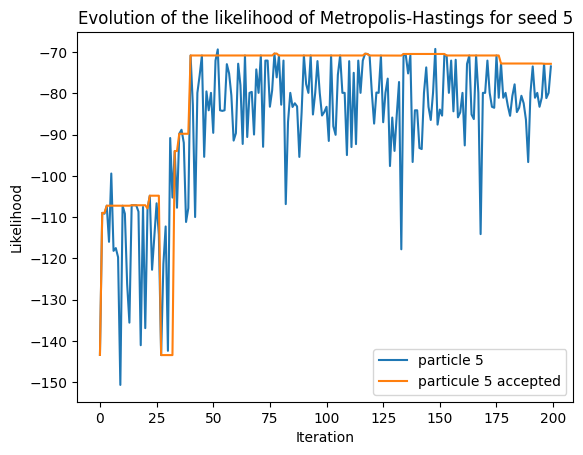

In [15]:
seed = 5
plt.figure()
plt.plot(all_likelihoods[seed, :-1], label="particle "+ str(seed))
plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis-Hastings for seed " + str(seed))
plt.show()


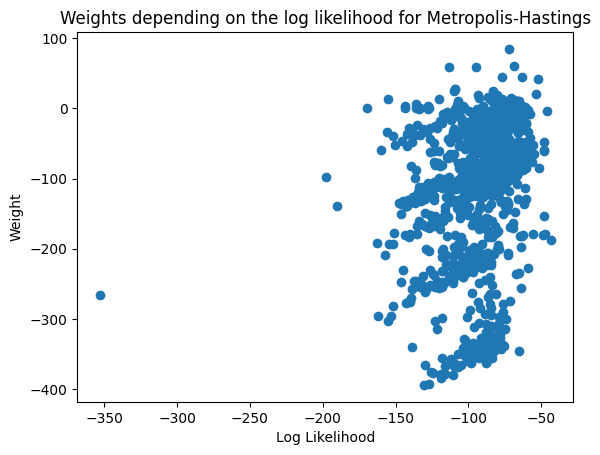

In [16]:
# Evolution of the weights depending on the likelihood
plt.figure()
plt.scatter(all_likelihoods.flatten(), all_weights.flatten())
plt.xlabel("Log Likelihood")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood for Metropolis-Hastings")
plt.show()


Text(0.5, 1.0, 'Weights depending on the log likelihood difference')

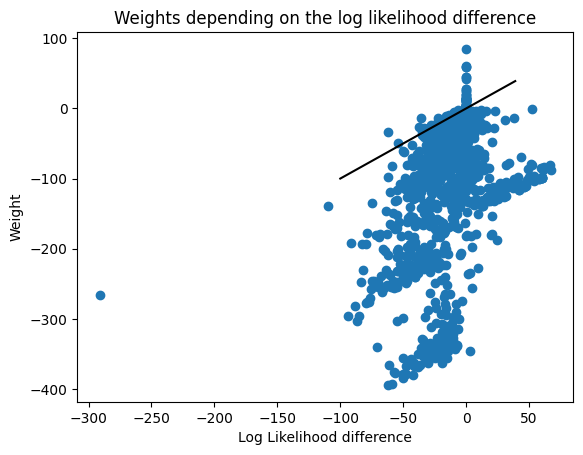

In [17]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood difference")

Text(0.5, 1.0, 'Difference of weights depending on the log likelihood difference')

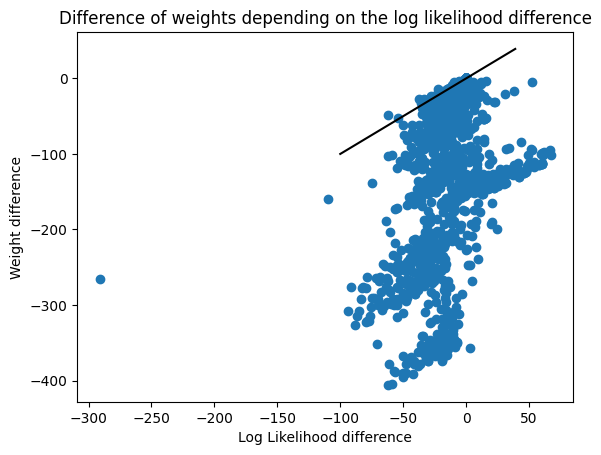

In [20]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1] - all_weights[_index, all_prev_rules_ind[:,1:]])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight difference")
plt.title("Difference of weights depending on the log likelihood difference")

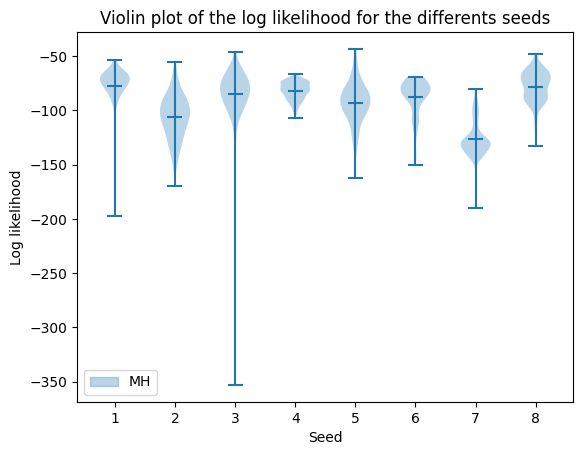

In [18]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_mh = plt.violinplot(all_likelihoods.transpose(), showmeans=True)["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
plt.legend([color_mh], ["MH"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()